# Bias correct atmospheric conditions

- spatially varying field that is constant in time
- Calculated from the difference between ERA5 1979-2015 time-mean and PACE ensemble-mean and time-mean

In [1]:
import xarray as xr
import numpy as np
import cmocean
import sys
sys.path.append('/home/users/birgal/')
import pickle
from nemo_python_git.utils import fix_lon_range, dewpoint_to_specific_humidity
from nemo_python_git.interpolation import regrid_array_cf, regrid_operator_cf, interp_latlon_cf
from nemo_python_git.file_io import find_cesm2_file, find_processed_cesm2_file
from nemo_python_git.constants import cesm2_ensemble_members, sec_per_day, sec_per_hour, rho_fw
from nemo_python_git.ics_obcs import fill_ocean

In [2]:
base_folder = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

### Start with thermodynamic variables (TREFHT, QREFHT, FLDS, FSDS, PRECT, PRECS, PSL)

In [3]:
def era5_time_mean_forcing(variable, year_start=1979, year_end=2015, out_file=None):

    ERA5_ds   = xr.open_mfdataset(f'{base_folder}ERA5-forcing/files/era5_{variable}_*_daily_averages.nc')
    ERA5_ds   = ERA5_ds.isel(time=((ERA5_ds.time.dt.year <= year_end)*(ERA5_ds.time.dt.year >= year_start)))
    time_mean = ERA5_ds.mean(dim='time') 

    if out_file:
        time_mean.to_netcdf(out_file)
    return time_mean

In [4]:
# Function calculates the time-mean over specified year range for mean of all CESM2 ensemble members in the specified experiment
# !!!! but should I be running this on my pre-processed files? or on the original? --- changes what I read in and whether I need to correct lon range
# Input:
# - expt : string of CESM2 experiment name (e.g. 'LE2')
# - variable : string of forcing variable name
# - (optional) year_start : start year for time averaging
# - (optional) end_year   : end year for time averaging
# - (optional) out_file   : path to file to write time mean to NetCDF in case you want to store it
# - (optional) ensemble_members : list of strings of ensemble members to average (defaults to all the ones that have been downloaded)
def cesm2_ensemble_time_mean_forcing(expt, variable, year_start=1979, year_end=2015, out_file=None, ensemble_members=cesm2_ensemble_members):

    # calculate ensemble mean for each year
    year_mean = xr.Dataset()
    for year in range(year_start, year_end+1):
        files_to_open = []
        for ens in ensemble_members:
            file_path     = find_processed_cesm2_file(expt, variable, ens, year)
            files_to_open += [file_path]
        # calculate ensemble mean    
        ens_files = xr.open_mfdataset(files_to_open, concat_dim='ens', combine='nested')
        ens_year  = ens_files[variable].isel(time=(ens_files.time.dt.year==year))
        ens_mean  = ens_year.mean(dim=['time','ens']) # dimensions should be x,y
        # save ensemble mean to xarray dataset
        if year == year_start:
            year_mean = ens_mean
        else:
            year_mean = xr.concat([year_mean, ens_mean], dim='year')
            
    # and then calculate time-mean of all ensemble means:
    time_mean = year_mean.mean(dim='year')
    if out_file:
        time_mean.to_netcdf(out_file)
    
    return time_mean.to_dataset()

In [6]:
def atm_bias_correction(source, variable, expt='LE2', year_start=1979, year_end=2015, 
                        ensemble_mean_file=None, era5_mean_file=None,
                        nemo_grid='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc',
                        nemo_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc',
                        out_folder='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'):

    # NEMO configuration domain_cfg file for regridding
    nemo_grid_ds = xr.open_dataset(nemo_grid).squeeze()
    
    # process_forcing_for_correction(source, variable)
    if source=='CESM2':
        # Read in ensemble time mean (or calculate it)
        if ensemble_mean_file:
            CESM2_time_mean = xr.open_dataset(ensemble_mean_file)
        else:
            CESM2_time_mean = cesm2_ensemble_time_mean_forcing(expt, variable, year_start=year_start, year_end=year_end)

        # Read in time mean of ERA5 files (or calculate it)
        if era5_mean_file:
            ERA5_time_mean = xr.open_dataset(era5_mean_file)
        else:
            CESM2_to_ERA5_varnames = {'TREFHT':'t2m','FSDS':'ssrd','FLDS':'strd','QREFHT':'sph2m', 'PRECS':'sf', 'PRECT':'tp'} # I calculated specific humidity
            varname = CESM2_to_ERA5_varnames[variable]
            ERA5_time_mean = era5_time_mean_forcing(varname, year_start=year_start, year_end=year_end)
            if variable in ['PRECS','PRECT']:
                ERA5_time_mean *= rho_fw/sec_per_day # convert to match units
            elif variable in ['FLDS','FSDS']:
                ERA5_time_mean /= sec_per_hour # convert to match units
            elif variable=='QREFHT':
                varname='specific_humidity'
            ERA5_time_mean = ERA5_time_mean.rename({varname:variable, 'longitude':'lon', 'latitude':'lat'})
        
        # Adjust the longitude and regrid time means to NEMO configuration grid, so that they can be used to bias correct
        ERA5_time_mean['lon'] = fix_lon_range(ERA5_time_mean['lon'])        
        CESM2_source = CESM2_time_mean.sortby('lon')
        ERA5_source  = ERA5_time_mean.sortby('lon')
        CESM2_mean_interp = interp_latlon_cf(CESM2_source, nemo_grid_ds, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
        ERA5_mean_interp  = interp_latlon_cf(ERA5_source , nemo_grid_ds, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
        
        # thermodynamic correction
        if variable in ['TREFHT','QREFHT','FLDS','FSDS','PRECS','PRECT']:
            print('Correcting thermodynamics')
            out_file = f'{out_folder}{source}-{expt}_{variable}_bias_corr.nc'
            thermo_correction(variable, CESM2_mean_interp, ERA5_mean_interp, out_file)
        else:
            raise Exception(f'Variable {variable} does not need bias correction. Check that this is true.')
    else:
        raise Exception("Bias correction currently only set up to correct CESM2, sorry you'll need to write some more code")

    return

def thermo_correction(variable, CESM2_mean, ERA5_mean, out_file,
                      nemo_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'):
    
    # NEMO configuration domain_cfg file for regridding
    nemo_mask_ds = xr.open_dataset(nemo_mask).squeeze()

    # Calculate difference:
    bias = CESM2_mean - ERA5_mean
    # Mask land regions to zero:
    bias = xr.where(nemo_mask_ds.isel(nav_lev=0).tmask==0, 0, bias)

    # write to file
    bias.to_netcdf(out_file)
    
    return

In [7]:
for var in ['QREFHT']: #'FSDS','FLDS','PRECS','PRECT'
    print(var)
    atm_bias_correction('CESM2', var, year_start=1979, year_end=2015)

QREFHT


/home/users/birgal/.conda/envs/cf-env/lib/python3.12/site-packages/xarray/core/indexing.py:1621: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Correcting thermodynamics


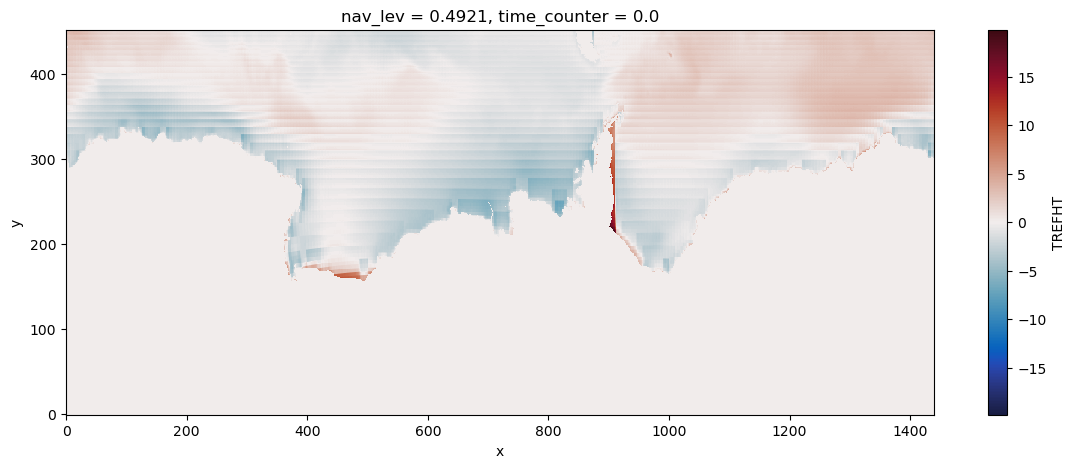

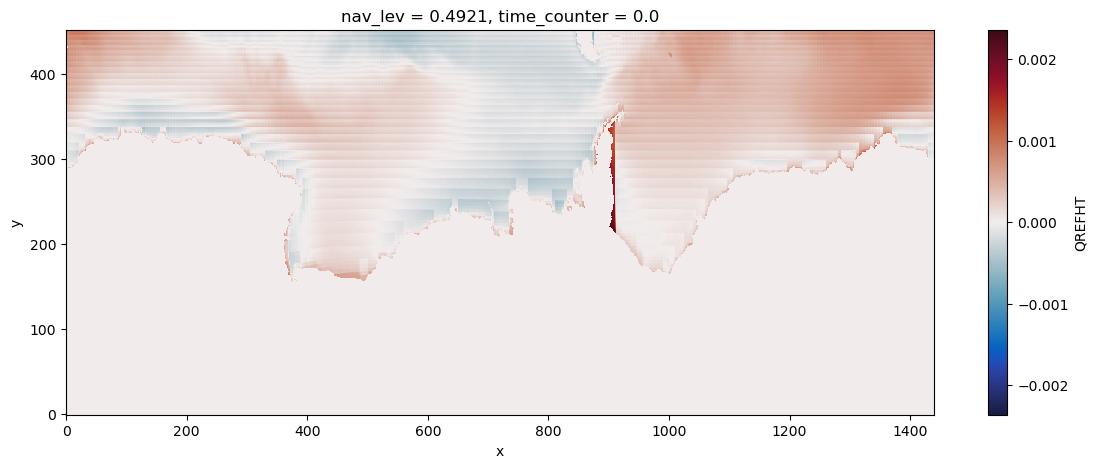

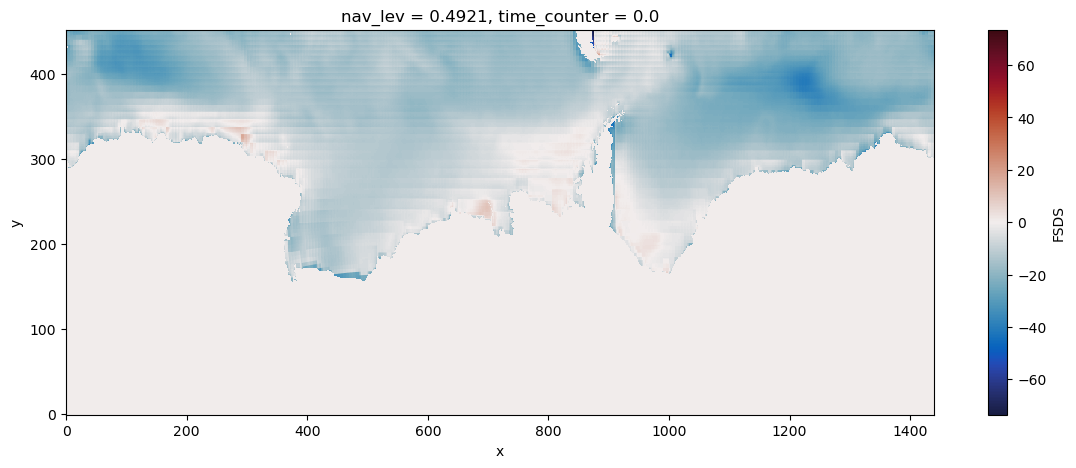

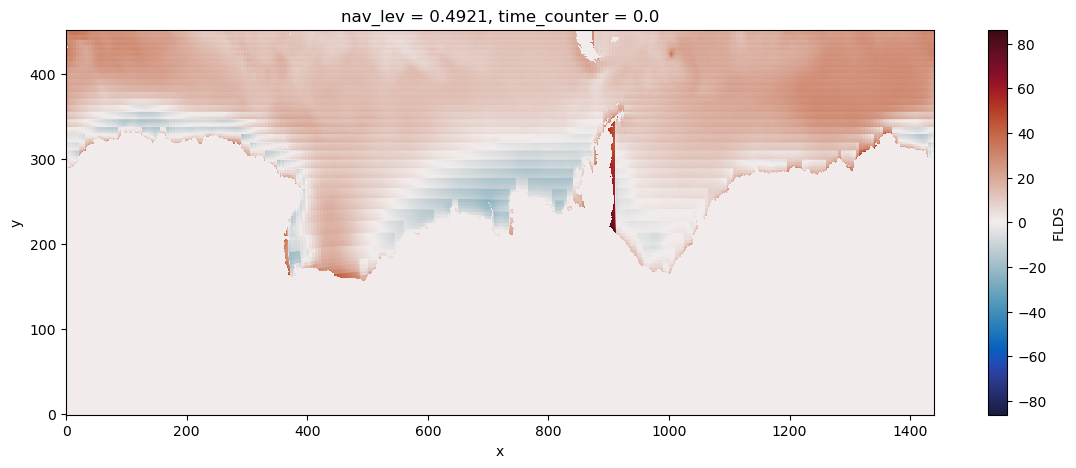

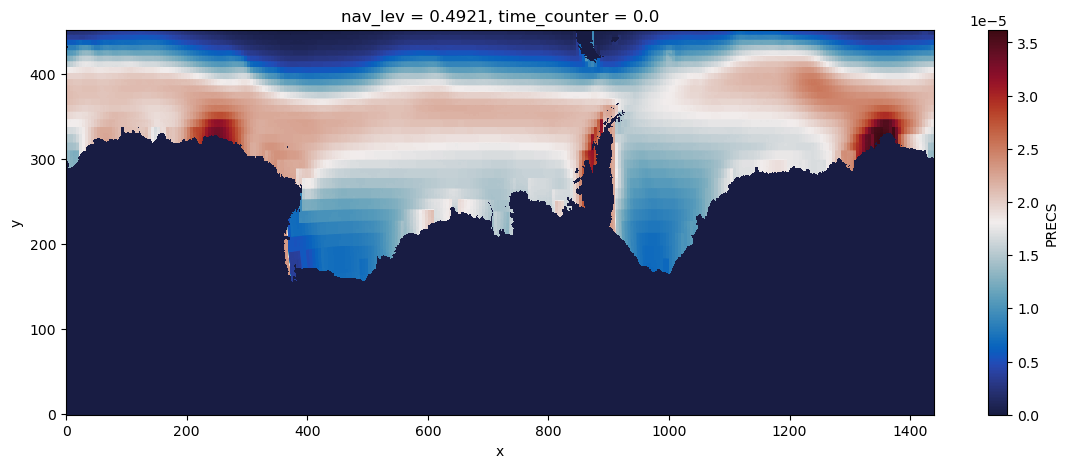

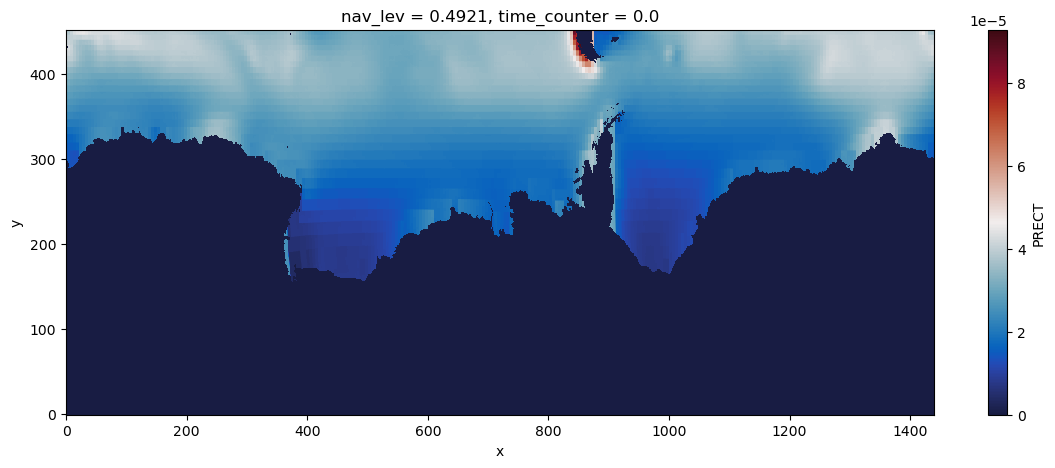

In [8]:
for var in ['TREFHT','QREFHT','FSDS','FLDS','PRECS','PRECT']:
    CESM2_corr = xr.open_dataset(f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/CESM2-LE2_{var}_bias_corr.nc')
    CESM2_corr[var].plot(figsize=(14,5), cmap=cmocean.cm.balance)

### Next up:
- write code in NEMO to read in these files
- double check that the correction field regrid matches that produced by NEMO by looking at read in output from a test